<a href="https://colab.research.google.com/github/LeylaY1996/sentiment-analysis-aws-reviews/blob/main/23112024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import pandas as pd

# Veri setini yükle
csv_file_path = '/content/Reviews.csv'  # Dosya yolunuza göre güncelleyin
df = pd.read_csv(csv_file_path, on_bad_lines='skip', quoting=3, low_memory=False)  # daha yeni versiyonlar için
# Veri setinin boyutunu yazdır
print("Orijinal veri seti boyutu:", df.shape)

# %50 oranında rastgele bir alt küme seç
sampled_df = df.sample(frac=0.2, random_state=42)  # random_state ile tekrarlanabilirlik sağlar

# Yeni veri setinin boyutunu yazdır
print("Yeni veri seti boyutu:", sampled_df.shape)

# İstediğiniz gibi veriyi kaydedin veya kullanın
sampled_df.to_csv('sampled_reviews.csv', index=False)  # Yeni dosyayı kaydet

Orijinal veri seti boyutu: (149388, 10)
Yeni veri seti boyutu: (29878, 10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


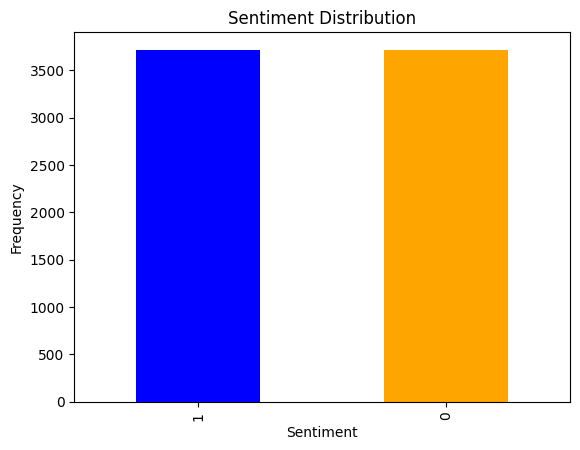

Ortalama Yorum Uzunluğu: 139.5739843960183
Standart Sapma: 89.73624131489571
Aykırı değerler çıkarıldıktan sonra veri seti boyutu: (7312, 2)


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
from scipy import stats

# NLTK stopwords yükle
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

def clean_text(text):
    """Metni temizler: küçük harfe çevirir, noktalama işaretlerini kaldırır ve durak kelimeleri filtreler."""
    text = text.lower()  # Küçük harfe çevir
    text = ''.join([char for char in text if char not in punctuation])  # Noktalama işaretlerini kaldır
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Durak kelimeleri filtrele
    return text

def prepare_data(csv_file):
    """Veri setini hazırlar: yükler, temizler ve etiketler."""

    # Veri setini yükle
    df = pd.read_csv(csv_file)

    # Gerekli sütunları seçin
    df = df[['Text', 'Score']]

    # 3 değerine sahip satırları çıkarın
    df = df[df['Score'] != 3]

    # Skorları ikili hale getirin (örneğin: 1-2 olumsuz, 4-5 olumlu)
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)

    # Yorumları temizle
    df['cleaned_review'] = df['Text'].apply(clean_text)

    # Sadece temizlenmiş yorumlar ve duygu etiketlerini içeren DataFrame döndür
    return df[['cleaned_review', 'Sentiment']]

# Veriyi yükle ve hazırla
csv_file_path = '/content/sampled_reviews.csv'  # Dosya yolunuza göre güncelleyin
prepared_data = prepare_data(csv_file_path)

# Veri dengesini sağlama
# Olumlu ve olumsuz örneklerin sayısını bul
positive_samples = prepared_data[prepared_data['Sentiment'] == 1]
negative_samples = prepared_data[prepared_data['Sentiment'] == 0]

# Minimum sayıda olan sınıfa göre dengeleme
min_samples = min(len(positive_samples), len(negative_samples))
balanced_data = pd.concat([positive_samples.sample(min_samples, random_state=42),
                           negative_samples.sample(min_samples, random_state=42)])

# Histogram çizme
balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

# Ortalama ve standart sapma hesaplama
mean_length = balanced_data['cleaned_review'].apply(len).mean()
std_length = balanced_data['cleaned_review'].apply(len).std()
print(f"Ortalama Yorum Uzunluğu: {mean_length}")
print(f"Standart Sapma: {std_length}")

# Aykırı değer kontrolü (örneğin, yorum uzunluğuna göre aykırı değer)
z_scores = np.abs(stats.zscore(balanced_data['cleaned_review'].apply(len)))
balanced_data = balanced_data[(z_scores < 3)]

print("Aykırı değerler çıkarıldıktan sonra veri seti boyutu:", balanced_data.shape)

In [56]:
# Confusion Matrix'i görselleştir
def plot_confusion_matrix(cm):
    """Confusion matrix'i görselleştirir."""
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(cm, cmap='Blues', alpha=0.6)
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', ha='center', va='center', color='red')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

SVM with SMOTE Accuracy (Balanced Data): 0.8872180451127819
SVM with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       728
           1       0.90      0.87      0.89       735

    accuracy                           0.89      1463
   macro avg       0.89      0.89      0.89      1463
weighted avg       0.89      0.89      0.89      1463

SVM with SMOTE Confusion Matrix (Balanced Data):
 [[661  67]
 [ 98 637]]


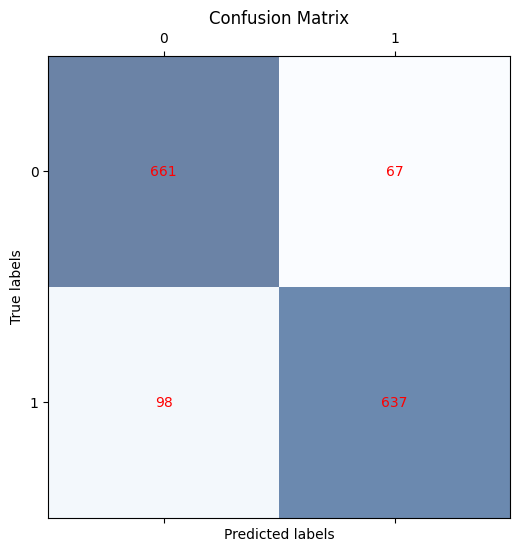

In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def svm_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile SVM (Support Vector Machine) ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır, sınıf dengesini korumak için stratify kullan
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']  # Stratify ile sınıf dengesini korur
    )

    # TF-IDF vektörleştirme - Bigrams kullanarak özellik sayısını artırıyoruz
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # 1. ve 2. n-gramları kullanıyoruz
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SMOTE ile azınlık sınıfını artırma
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # SVM modelini oluştur ve eğit
    model = SVC(kernel='linear', class_weight='balanced', random_state=42)  # SVM modelini oluşturuyoruz
    model.fit(X_train_resampled, y_train_resampled)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Accuracy, Classification Report ve Confusion Matrix'i döndür
    return accuracy, report, cm

# SVM analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm = svm_with_smote_sentiment_analysis_balanced(balanced_data)

# Sonuçları yazdır
print("SVM with SMOTE Accuracy (Balanced Data):", accuracy)
print("SVM with SMOTE Classification Report (Balanced Data):\n", report)
print("SVM with SMOTE Confusion Matrix (Balanced Data):\n", cm)

plot_confusion_matrix(cm)

Naive Bayes with SMOTE Accuracy (Balanced Data): 0.8920027341079972
Naive Bayes with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       728
           1       0.88      0.91      0.89       735

    accuracy                           0.89      1463
   macro avg       0.89      0.89      0.89      1463
weighted avg       0.89      0.89      0.89      1463

Naive Bayes with SMOTE Confusion Matrix (Balanced Data):
 [[639  89]
 [ 69 666]]


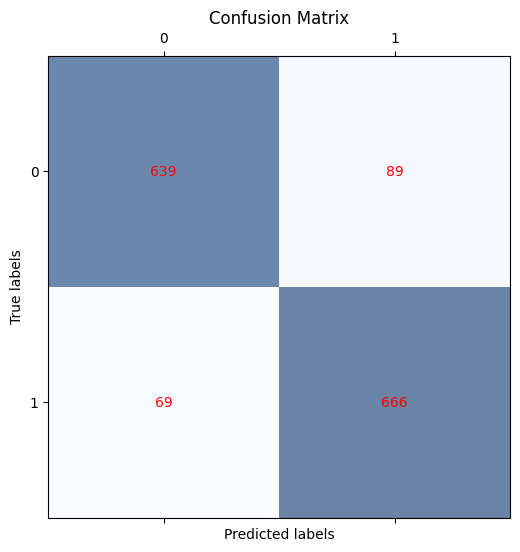

In [58]:
from sklearn.naive_bayes import MultinomialNB

def naive_bayes_sentiment_analysis_with_smote_balanced(df):
    """Balanced veri seti ile Naive Bayes (MultinomialNB) ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""

    # Veriyi eğitim ve test setine ayır, sınıf dengesini korumak için stratify kullan
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']  # Stratify ile sınıf dengesini korur
    )

    # TF-IDF vektörleştirme - Bigrams kullanarak özellik sayısını artırıyoruz
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))  # 1. ve 2. n-gramları kullanıyoruz
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # SMOTE ile azınlık sınıfını artırma
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # Naive Bayes modelini oluştur ve eğit
    model = MultinomialNB(alpha=1.0)  # Alpha parametresi smoothing için kullanılır
    model.fit(X_train_resampled, y_train_resampled)

    # Tahmin yap
    y_pred = model.predict(X_test_tfidf)

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Accuracy, Classification Report ve Confusion Matrix'i döndür
    return accuracy, report, cm

# Naive Bayes analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm = naive_bayes_sentiment_analysis_with_smote_balanced(balanced_data)

# Sonuçları yazdır
print("Naive Bayes with SMOTE Accuracy (Balanced Data):", accuracy)
print("Naive Bayes with SMOTE Classification Report (Balanced Data):\n", report)
print("Naive Bayes with SMOTE Confusion Matrix (Balanced Data):\n", cm)

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 479ms/step - accuracy: 0.5718 - loss: 0.8783 - val_accuracy: 0.8366 - val_loss: 0.3944
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 439ms/step - accuracy: 0.9231 - loss: 0.2988 - val_accuracy: 0.8510 - val_loss: 0.4096
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 40s 436ms/step - accuracy: 0.9702 - loss: 0.1364 - val_accuracy: 0.8517 - val_loss: 0.4433
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 446ms/step - accuracy: 0.9836 - loss: 0.0835 - val_accuracy: 0.8660 - val_loss: 0.4567
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 442ms/step - accuracy: 0.9926 - loss: 0.0409 - val_accuracy: 0.8606 - val_loss: 0.5594
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 475ms/step - accuracy: 0.9899 - loss: 0.0403 - val_accuracy: 0.8626 - val_loss: 0.5447
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 433ms/step - accuracy: 0.9949 - loss: 0.0308 - val_accuracy: 0.8660 - val_loss: 0.6361
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9976 - loss: 0.0184 - val_accu

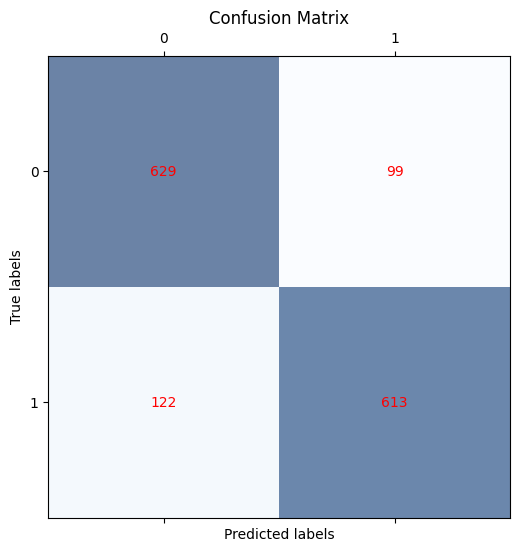

In [59]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

def redesigned_rnn_with_balancing_smote(df):
    """Daha iyi performans için yeniden tasarlanmış RNN (Bidirectional LSTM) ve SMOTE ile duygu analizi."""

    # Eğitim ve test seti ayırma
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']
    )

    # Metinleri sayısal verilere dönüştürmek için Keras'ın Tokenizer'ını kullanıyoruz
    from tensorflow.keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    # Veriyi sayısal verilere dönüştürme
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Veriyi belirli bir uzunluğa sıfırlama (padding)
    max_length = 100
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

    # SMOTE ile veri dengesini sağlama
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_padded, y_train)

    # Model yapısı
    model = Sequential()

    # Embedding katmanı, kelimeleri yerleşik vektörler ile temsil eder
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))

    # Bidirectional LSTM katmanı
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))

    # İkinci LSTM katmanı
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Sınıf ağırlıkları ile derleme
    class_weights = {0: 2, 1: 1}  # Sınıflar arasında denge sağlamak için ağırlıklar
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Modeli eğit
    model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test), class_weight=class_weights)

    # Test verisi üzerinde tahmin yap
    y_pred = (model.predict(X_test_padded) > 0.5).astype("int32").flatten()

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Sonuçları döndürme
    return accuracy, report, cm

# Balanced data ile modeli çalıştırma
accuracy, report, cm = redesigned_rnn_with_balancing_smote(balanced_data)

# Sonuçları yazdır
print("SMOTE ile dengelenmiş RNN Accuracy:", accuracy)
print("SMOTE ile dengelenmiş RNN Classification Report:\n", report)
print("SMOTE ile dengelenmiş RNN Confusion Matrix:\n", cm)

plot_confusion_matrix(cm)

Lexicon-Based SMOTE Accuracy: 0.6476190476190476
Lexicon-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.82      0.70      3675
           1       0.73      0.47      0.57      3675

    accuracy                           0.65      7350
   macro avg       0.67      0.65      0.64      7350
weighted avg       0.67      0.65      0.64      7350

Lexicon-Based SMOTE Confusion Matrix:
 [[3030  645]
 [1945 1730]]


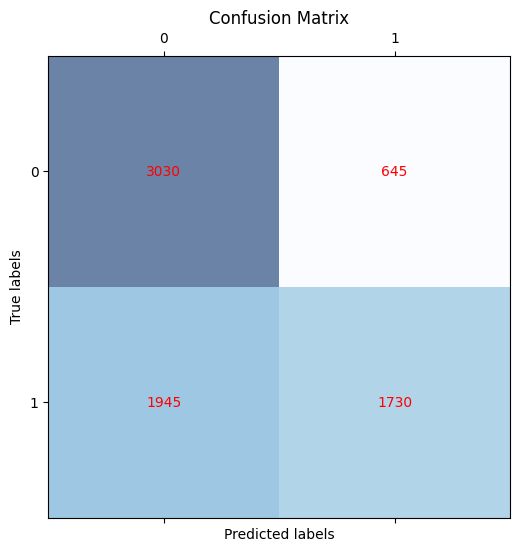

In [60]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Pozitif ve negatif kelimelerin listesi
positive_words = ['good', 'great', 'excellent', 'awesome', 'nice']
negative_words = ['bad', 'terrible', 'poor', 'worst', 'awful']

def lexicon_based_sentiment_analysis_with_smote_balanced(df):
    """Lexicon-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her yorumdaki kelimeleri analiz ederek duygu puanı döndür
    def get_sentiment(text):
        words = text.split()
        score = 0
        for word in words:
            if word in positive_words:
                score += 1
            elif word in negative_words:
                score -= 1
        return 1 if score > 0 else 0

    # Duygu etiketlerini tahmin et
    df['Lexicon_Sentiment'] = df['cleaned_review'].apply(get_sentiment)

    # SMOTE uygulama
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(df['Lexicon_Sentiment'].values.reshape(-1, 1), df['Sentiment'])

    # Tahminleri değerlendirme
    accuracy = accuracy_score(y_res, X_res)
    report = classification_report(y_res, X_res)
    cm = confusion_matrix(y_res, X_res)

    # Sonuçları yazdır
    print("Lexicon-Based SMOTE Accuracy:", accuracy)
    print("Lexicon-Based SMOTE Classification Report:\n", report)
    print("Lexicon-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix'i görselleştir
    plot_confusion_matrix(cm)

    return accuracy, report, cm

# Lexicon-based fonksiyonunu balanced_data ile çağırma
accuracy, report, cm = lexicon_based_sentiment_analysis_with_smote_balanced(balanced_data)

Aspect-Based SMOTE Accuracy: 0.6448979591836734
Aspect-Based SMOTE Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.83      0.70      3675
           1       0.73      0.46      0.56      3675

    accuracy                           0.64      7350
   macro avg       0.67      0.64      0.63      7350
weighted avg       0.67      0.64      0.63      7350

Aspect-Based SMOTE Confusion Matrix:
 [[3059  616]
 [1994 1681]]


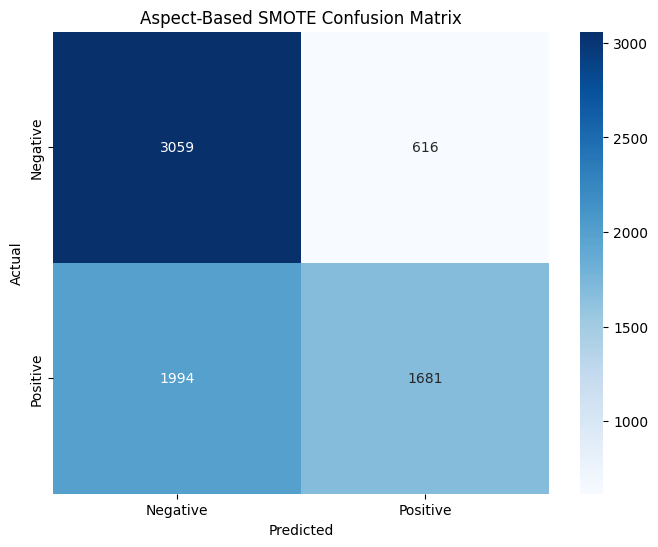

In [63]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Aspect kelime listeleri
aspects = {
    'hız': ['fast', 'quick', 'speed', 'late', 'delayed'],
    'kalite': ['good', 'great', 'excellent', 'poor', 'bad', 'terrible', 'quality']
}

def aspect_based_sentiment_analysis_with_smote_balanced(df):
    """Aspect-based sentiment analizi SMOTE ile ve balanced_data kullanarak."""

    # Her özellik için duygu analizi yap
    def get_aspect_sentiment(text):
        words = text.split()
        aspect_scores = {aspect: 0 for aspect in aspects.keys()}
        for word in words:
            for aspect, keywords in aspects.items():
                if word in keywords:
                    aspect_scores[aspect] += 1
        return aspect_scores['hız'], aspect_scores['kalite']

    # Her bir yorum için aspect-based duygu analizi yap
    df[['Aspect_Hız', 'Aspect_Kalite']] = df['cleaned_review'].apply(get_aspect_sentiment).apply(pd.Series)

    # Kelime sıklığı (word count) kullanarak daha fazla özellik çıkaralım
    vectorizer = CountVectorizer(vocabulary=sum(aspects.values(), []))
    X_aspects = vectorizer.fit_transform(df['cleaned_review']).toarray()

    # SMOTE uygulama (X: feature, y: label)
    smote = SMOTE(k_neighbors=3, random_state=42)

    X_res = X_aspects  # Tüm özellikler
    y_res = df['Sentiment']  # Etiketler
    X_res, y_res = smote.fit_resample(X_res, y_res)

    # RandomForestClassifier ile model tanımlama (class_weight kullanımı burada yapılır)
    model = RandomForestClassifier(random_state=42)

    # Modelin eğitilmesi ve değerlendirilmesi
    model.fit(X_res, y_res)
    y_pred = model.predict(X_res)

    accuracy = accuracy_score(y_res, y_pred)
    report = classification_report(y_res, y_pred)
    cm = confusion_matrix(y_res, y_pred)

    # Sonuçları yazdır
    print("Aspect-Based SMOTE Accuracy:", accuracy)
    print("Aspect-Based SMOTE Classification Report:\n", report)
    print("Aspect-Based SMOTE Confusion Matrix:\n", cm)

    # Confusion matrix görselleştirme
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title("Aspect-Based SMOTE Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, report, cm

# Aspect-based fonksiyonunu balanced_data ile çağırma
accuracy, report, cm = aspect_based_sentiment_analysis_with_smote_balanced(balanced_data)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7125 - loss: 0.6186 - val_accuracy: 0.8961 - val_loss: 0.2690
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9535 - loss: 0.1376 - val_accuracy: 0.8886 - val_loss: 0.2920
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9936 - loss: 0.0357 - val_accuracy: 0.8859 - val_loss: 0.3551
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9986 - loss: 0.0137 - val_accuracy: 0.8824 - val_loss: 0.4075
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.8817 - val_loss: 0.4364
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CNN with SMOTE Accuracy (Balanced Data): 0.8817498291182502
CNN with SMOTE Classification Report (Balanced Data):
               precision    recall  f1-score   support

           0       0.87      0.90      0.88       728
           1       0.89      0.87      0.88       735

    accuracy                           0.88      146

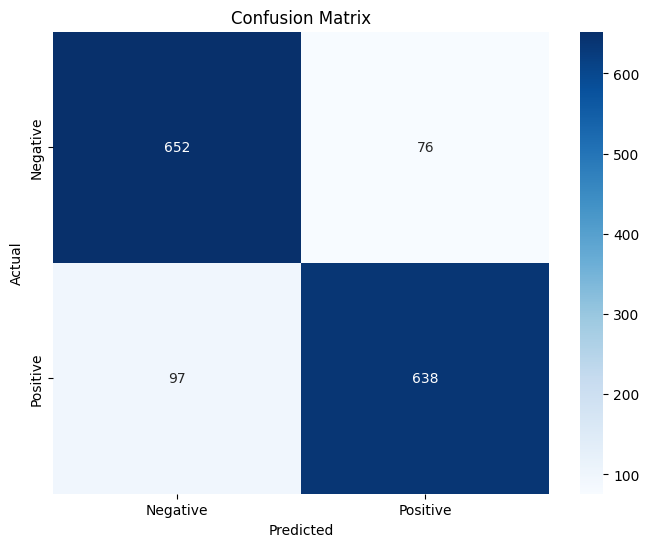

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels):
    """Confusion Matrix'i görselleştirmek için yardımcı fonksiyon."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def cnn_with_smote_sentiment_analysis_balanced(df):
    """Balanced veri seti ile CNN ve SMOTE kullanarak duygu analizi yapar ve sonuçları döner."""
    # Veriyi eğitim ve test setine ayır
    X_train, X_test, y_train, y_test = train_test_split(
        df['cleaned_review'],
        df['Sentiment'],
        test_size=0.2,
        random_state=42,
        stratify=df['Sentiment']  # Stratify ile sınıf dengesini korur
    )

    # TF-IDF vektörleştirme
    vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
    X_test_tfidf = vectorizer.transform(X_test).toarray()

    # SMOTE ile veri artırımı
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

    # CNN Modelini oluştur
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary sınıflandırma için sigmoid
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Modeli eğit
    model.fit(
        X_train_resampled, y_train_resampled,
        epochs=5,
        batch_size=64,
        validation_data=(X_test_tfidf, y_test)
    )

    # Test seti üzerinde tahmin yap
    y_pred = model.predict(X_test_tfidf)
    y_pred = (y_pred > 0.5).astype(int).flatten()  # Sigmoid çıktıyı 0 veya 1'e dönüştür

    # Sonuçları değerlendir
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, report, cm, ['Negative', 'Positive']

# CNN analizi SMOTE ile balanced_data kullanılarak
accuracy, report, cm, labels = cnn_with_smote_sentiment_analysis_balanced(balanced_data)

# Sonuçları yazdır
print("CNN with SMOTE Accuracy (Balanced Data):", accuracy)
print("CNN with SMOTE Classification Report (Balanced Data):\n", report)
print("CNN with SMOTE Confusion Matrix (Balanced Data):\n", cm)

# Confusion Matrix'i görselleştir
plot_confusion_matrix(cm, labels)